In [1]:
# load and transform the data
import pandas as pd
df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

import numpy as np


# binary transformation of categorical attribute needed
df_heart['famhist'] = df_heart['famhist'].map({'Present': 1, 'Absent': 0})

# log transform skewed columns as described in part 1:
columns_to_log_transform = ['tobacco','alcohol']
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

# center the data to have mean = 0 and variance = 1
# manual scalation of the data returns very slightly different values due to float representation:
df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

df_heart_standarized.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.176594,-0.418017,0.628654,1.576878,1.772852,1,1.372375
2,0.276789,-0.159507,0.411694,0.670646,0.193134,1.381617,-1.193044,-0.563821,0,1.372375
3,-0.991731,-0.608585,0.883374,0.734723,-0.112441,0.217947,-1.120397,-0.259134,1,-0.727086
4,1.545310,0.806252,1.622382,1.411091,-0.214300,1.039361,1.116254,0.858159,1,1.372375
5,-0.211103,-0.598928,0.305020,-0.012842,0.702427,0.423301,1.702714,1.422062,1,1.372375


Data has been standardized and log transformations were applied to the features that were highly skewed, tobacco and alcohol. The binary category famhist have been transformed to 0 and 1.

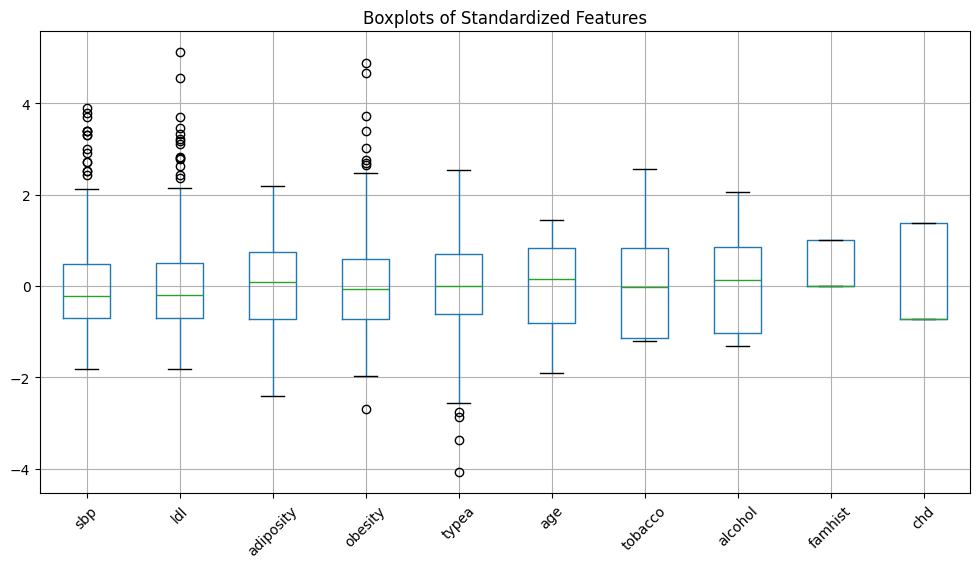

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df_heart_standarized.boxplot(rot=45)
plt.title("Boxplots of Standardized Features")
plt.show()

In [3]:
# use 6 pc's as found in project 1 to describe above 90% of the variance
from sklearn.decomposition import PCA
# drop the column we want to predict
X = df_heart_standarized.drop(columns=["sbp"])
y = df_heart_standarized["sbp"]

In [4]:
# sbp column has index 0
X = df_heart_standarized.iloc[:, 1:]  # DataFrame
y = df_heart_standarized.iloc[:, 0]

# Regression, Part B

In this section, we will compare three models:  
- the **regularized linear regression model** from the previous section,  
- an **artificial neural network (ANN)**, and  
- a **baseline** model.  

We are interested in two main questions:  
1. Is one model better than the other?  
2. Is either model better than a trivial baseline?  

We will attempt to answer these questions using **two-level cross-validation**.

---

## 1. Two-Level Cross-Validation

Implement **two-level cross-validation** (see *Algorithm 6* of the lecture notes).  
We will use **K₁ = K₂ = 10 folds** to compare the models.

### Baseline Model
As a baseline, we will apply a **linear regression model with no features**, i.e. it computes the **mean of _y_** on the training data and uses this value to predict _y_ on the test data.

### ANN Model
Make sure you can fit an **ANN model** to the data.  
As a complexity-controlling parameter for the ANN, we will use the **number of hidden units (h)**.

Based on a few test runs:
- Select a **reasonable range of values** for _h_ (which should include _h = 1_).  
- Describe the range of values you will use for both **_h_** and **_λ_**.




---

What is the difference between a classification and regression model? The activation function used by the classification model was a Sigmoid which returns a value from 0 to 1 which allow us to classify values depending on the distance to each class, class 0 and class 1. 

In the regression model, we do not need one non-linear function after the output. This is because the Linear transformation applied after the hidden layer to transform the values into the output dimension is enough for getting the continuos value in a larger vector space. 

Why do we use ReLu for regression? Relu is a effective and simple activation function

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge

# ANN Model Functions
# define model initializer
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),
    )
# train the model using MSE loss and Adam optimizer
def train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01):
  
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model
# make predictions using the model
def predict_pytorch_model(model, X_test):
   
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_test)
        predictions = model(X_tensor).numpy().flatten()
    return predictions

# Ridge Regression Model Functions (using Part A)
def train_ridge_sklearn(X_train, y_train, lambda_reg):
    model = Ridge(alpha=lambda_reg, fit_intercept=True)
    model.fit(X_train, y_train)
    return model

def predict_ridge_sklearn(model, X_test):
    """Make predictions using trained sklearn Ridge model."""
    return model.predict(X_test)

To select a reasonable range of hidden units to test in the two-layer cross validation we first make a few runs using simple cross validation with 10 folds to estimate the generalization error of each number of hidden units.

In [6]:
# test the ANN model using 10 folds with different hidden units for all data
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
hidden_units_list = np.arange(1, 11)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

 # Convert to numpy arrays
X = np.array(X)
y = np.array(y)
for hidden_units in hidden_units_list:
    fold_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # standardize data manually
        mean_train = X_train.mean(axis=0)
        std_train = X_train.std(axis=0)
        X_train = (X_train - mean_train) / std_train
        X_test = (X_test - mean_train) / std_train
        
        model = get_model(input_dim=X.shape[1], hidden_dim=hidden_units, output_dim=1)
        model = train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01)
        y_pred = predict_pytorch_model(model, X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    results[hidden_units] = np.mean(fold_mse)

results_df_hidden_units = pd.DataFrame(list(results.items()), columns=["Hidden Units", "Mean MSE"])
print(results_df_hidden_units)

   Hidden Units  Mean MSE
0             1  0.862771
1             2  0.886025
2             3  0.924225
3             4  0.899712
4             5  1.007512
5             6  1.103824
6             7  1.063135
7             8  1.106358
8             9  1.177790
9            10  1.354060


We observe that as the number of hidden units increases, the mean squared error tends to rise when tested on both the general data and the PCA-transformed data. The optimal number of hidden units appears to range between 1 and 5, showing the lowest generalization error in the simple 10-fold cross-validation.

Additionally, we notice a slightly lower MSE when using the PCA-transformed data.

## Explanation: Nested Cross-Validation Function

This function implements **two-level (nested) cross-validation** to compare three models:
1. **Baseline**: Predicts the mean of y (no features)
2. **Ridge Regression**: Regularized linear regression with optimal λ* selected via inner CV
3. **ANN**: Neural network with optimal h* (hidden units) selected via inner CV

### How Results from Part A are Used:

- **Lambda range**: From Part A, we found that λ values in the range `np.concatenate([[0.0], np.logspace(-4, 4, 200)])` (0.0 to 10,000) work well. This range is used as the default `lambda_range` parameter.
- **Ridge Regression code**: We use sklearn's `Ridge` model (same as Part A) with `train_ridge_sklearn`/`predict_ridge_sklearn` functions.

### Step-by-Step Process:

#### **Level 1: Outer Cross-Validation (10 folds)**
For each of the 10 outer folds:
1. **Split data**: Divide into outer training set (90%) and outer test set (10%)
2. **Standardize**: Standardize features using mean/std from outer training set only
3. **Evaluate three models** (all use the same train/test split for fair comparison):

#### **Level 2: Inner Cross-Validation (10 folds) - For Hyperparameter Selection**

**For Ridge Regression (λ selection):**
- For each λ in the range (100 values from Part A):
  - Perform 10-fold inner CV on the outer training set
  - For each inner fold: train Ridge model, evaluate on inner validation set
  - Compute average MSE across inner folds
- **Select optimal λ***: The λ with lowest average inner CV error
- **Train final model**: Train Ridge regression on entire outer training set with optimal λ*
- **Evaluate**: Test on outer test set → get `linreg_test_error`

**For ANN (h selection):**
- For each h in `hidden_units_range` (e.g., [1, 2, 3]):
  - Perform 10-fold inner CV on the outer training set
  - For each inner fold: train ANN, evaluate on inner validation set
  - Compute average MSE across inner folds
- **Select optimal h***: The h with lowest average inner CV error
- **Train final model**: Train ANN on entire outer training set with optimal h*
- **Evaluate**: Test on outer test set → get `ann_test_error`

**For Baseline:**
- Simply compute mean of y from outer training set
- **Evaluate**: Test on outer test set → get `baseline_test_error`

### Results We Get:

1. **`results_df`**: DataFrame with one row per outer fold containing:
   - `outer_fold`: Fold number (1-10)
   - `h_star`: Optimal hidden units for that fold
   - `lambda_star`: Optimal λ for that fold
   - `ann_test_error`: ANN test error on that fold
   - `linreg_test_error`: Ridge regression test error on that fold
   - `baseline_test_error`: Baseline test error on that fold

2. **`summary_table`**: Formatted table matching the assignment format (Table 1)

3. **`inner_errors_df`**: DataFrame with inner CV errors for ANN (for visualization/analysis)

4. **`best_model`**: String indicating which model performed best overall (lowest mean test error)

### Key Points:

- **Same splits for all models**: All three models use identical outer train/test splits, allowing fair statistical comparison
- **Hyperparameter selection**: λ* and h* are selected independently for each outer fold via inner CV
- **Unbiased evaluation**: Outer test set is never used for hyperparameter selection, giving unbiased performance estimates


In [7]:
# We compare the best linear model against the best ANN for the outer-folds based on those that obtain the best results of the inner folds.

In [8]:
def nested_cross_validation(X, y, hidden_units_range=[1, 2, 3, 4, 5],
                           lambda_range=None,
                           outer_folds=10, inner_folds=10, random_state=42,
                           epochs=1000, lr=0.01):
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if lambda_range is None:
        lambda_range = np.concatenate([[0.0], np.logspace(-4, 4, 200)])

    # outer cross-validation
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    # Store esults for each outer fold
    outer_fold_results = []
    all_inner_errors = []
    all_inner_errors_lambda = []
    
    # outer fold loop
    for outer_idx, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X), 1):
        print(f"\nProcessing Outer Fold {outer_idx}/{outer_folds}")
        print("-" * 50)

        X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
        y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

        # Standardize the data manually for each outer fold
        # Compute mean and std from training data only
        mean_outer = X_train_outer.mean(axis=0)
        std_outer = X_train_outer.std(axis=0)

        # Apply the same transformation to both training and test sets
        X_train_outer_scaled = (X_train_outer - mean_outer) / std_outer
        X_test_outer_scaled = (X_test_outer - mean_outer) / std_outer

        # BASELINE MODEL: Predict mean
        baseline_prediction = np.mean(y_train_outer)
        baseline_test_error = mean_squared_error(y_test_outer, 
                                                  np.full(len(y_test_outer), baseline_prediction))
        print(f"Baseline test error: {baseline_test_error:.6f}")

        # INNER CROSS-VALIDATION: Create splits once, then test both hyperparameters
        print(f"\n  Setting up Inner CV with {inner_folds} folds...")
        inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
        
        # Pre-compute all inner splits (store as list of tuples)
        inner_splits = list(inner_cv.split(X_train_outer_scaled))
        print(f"  Created {len(inner_splits)} inner train/validation splits")
        
        # HYPERPARAMETER SELECTION: Test λ range (Ridge Regression)
        print(f"\n  Testing {len(lambda_range)} λ values for Ridge Regression...")
        best_lambda = None
        best_inner_error_lambda = float('inf')
        lambda_results = []

        for lam in lambda_range:
            inner_fold_errors_lambda = []
            
            # Use pre-computed inner splits
            for inner_fold_idx, (train_inner_idx, val_inner_idx) in enumerate(inner_splits, 1):
                X_train_inner = X_train_outer_scaled[train_inner_idx]
                X_val_inner = X_train_outer_scaled[val_inner_idx]
                y_train_inner = y_train_outer[train_inner_idx]
                y_val_inner = y_train_outer[val_inner_idx]

                # Train Ridge regression model using sklearn (same as Part A)
                ridge_model = train_ridge_sklearn(X_train_inner, y_train_inner, lambda_reg=lam)

                # Predict on validation set
                y_pred_inner = predict_ridge_sklearn(ridge_model, X_val_inner)
                mse = mean_squared_error(y_val_inner, y_pred_inner)
                inner_fold_errors_lambda.append(mse)

            # Average error across inner folds
            avg_inner_error_lambda = np.mean(inner_fold_errors_lambda)
            std_inner_error_lambda = np.std(inner_fold_errors_lambda)

            # Store for plotting
            all_inner_errors_lambda.append({
                'outer_fold': outer_idx,
                'lambda': lam,
                'avg_mse': avg_inner_error_lambda
            })
            
            lambda_results.append({
                'lambda': lam,
                'avg_mse': avg_inner_error_lambda,
                'std_mse': std_inner_error_lambda
            })

            # Track best lambda
            if avg_inner_error_lambda < best_inner_error_lambda:
                best_inner_error_lambda = avg_inner_error_lambda
                best_lambda = lam

        # Print summary of λ selection
        print(f"  Best λ* = {best_lambda:.6f} (avg inner CV MSE: {best_inner_error_lambda:.6f})")

        # final Ridge regression model on entire outer training set
        final_ridge_model = train_ridge_sklearn(X_train_outer_scaled, y_train_outer, lambda_reg=best_lambda)
        y_pred_linreg = predict_ridge_sklearn(final_ridge_model, X_test_outer_scaled)
        linreg_test_error = mean_squared_error(y_test_outer, y_pred_linreg)
        print(f"  Linear Regression test error: {linreg_test_error:.6f}")

        # ========================================================================
        # HYPERPARAMETER SELECTION: Test h range (ANN)
        # ========================================================================
        print(f"\n  Testing {len(hidden_units_range)} hidden unit values for ANN...")
        best_hidden_units = None
        best_inner_error = float('inf')
        h_results = []

        for h in hidden_units_range:
            inner_fold_errors = []

            # Use pre-computed inner splits (same splits as for λ)
            for inner_fold_idx, (train_inner_idx, val_inner_idx) in enumerate(inner_splits, 1):
                X_train_inner = X_train_outer_scaled[train_inner_idx]
                X_val_inner = X_train_outer_scaled[val_inner_idx]
                y_train_inner = y_train_outer[train_inner_idx]
                y_val_inner = y_train_outer[val_inner_idx]

                # Standardize the data for each inner fold (for ANN)
                mean_inner = X_train_inner.mean(axis=0)
                std_inner = X_train_inner.std(axis=0)

                # Apply same scaling to both sets
                X_train_inner_scaled = (X_train_inner - mean_inner) / std_inner
                X_val_inner_scaled = (X_val_inner - mean_inner) / std_inner

                # Train neural network
                model = get_model(input_dim=X_train_inner.shape[1], 
                                hidden_dim=h, 
                                output_dim=1)
                model = train_pytorch_model(model, X_train_inner_scaled, y_train_inner, 
                                          epochs=epochs, lr=lr)

                # Predict on validation set
                y_pred_inner = predict_pytorch_model(model, X_val_inner_scaled)
                mse = mean_squared_error(y_val_inner, y_pred_inner)
                inner_fold_errors.append(mse)

            # Average error across inner folds
            avg_inner_error = np.mean(inner_fold_errors)
            std_inner_error = np.std(inner_fold_errors)

            # Store for plotting
            all_inner_errors.append({
                'outer_fold': outer_idx,
                'hidden_units': h,
                'avg_mse': avg_inner_error
            })
            
            h_results.append({
                'hidden_units': h,
                'avg_mse': avg_inner_error,
                'std_mse': std_inner_error
            })

            # Track best hidden units
            if avg_inner_error < best_inner_error:
                best_inner_error = avg_inner_error
                best_hidden_units = h

        # Print summary of h selection
        print(f"  Best h* = {best_hidden_units} (avg inner CV MSE: {best_inner_error:.6f})")
        print(f"  h selection results:")
        for res in h_results:
            marker = " <-- BEST" if res['hidden_units'] == best_hidden_units else ""
            print(f"    h={res['hidden_units']}: MSE={res['avg_mse']:.6f} ± {res['std_mse']:.6f}{marker}")

        # Train final neural network on entire outer training set
        final_model = get_model(input_dim=X_train_outer_scaled.shape[1], 
                               hidden_dim=best_hidden_units, 
                               output_dim=1)
        final_model = train_pytorch_model(final_model, X_train_outer_scaled, y_train_outer,
                                         epochs=epochs, lr=lr)
        y_pred_outer = predict_pytorch_model(final_model, X_test_outer_scaled)
        ann_test_error = mean_squared_error(y_test_outer, y_pred_outer)
        print(f"  ANN test error: {ann_test_error:.6f}")

        # Store results for this outer fold
        outer_fold_results.append({
            'outer_fold': outer_idx,
            'h_star': best_hidden_units,
            'lambda_star': best_lambda,
            'ann_test_error': ann_test_error,
            'linreg_test_error': linreg_test_error,
            'baseline_test_error': baseline_test_error
        })

    # Create results dataframe
    results_df = pd.DataFrame(outer_fold_results)
    inner_errors_df = pd.DataFrame(all_inner_errors)

    # Create summary table in the format shown
    summary_table = pd.DataFrame({
        'Outer fold': results_df['outer_fold'],
        'ANN h*': results_df['h_star'],
        'ANN E^test': results_df['ann_test_error'],
        'LinReg λ*': results_df['lambda_star'],
        'LinReg E^test': results_df['linreg_test_error'],
        'Baseline E^test': results_df['baseline_test_error']
    })

    # Print summary table
    print("\n" + "=" * 80)
    print("OUTER FOLD RESULTS TABLE")
    print(summary_table.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("GENERALIZATION ERROR STATISTICS")
    print(f"ANN Mean Test Error:              {results_df['ann_test_error'].mean():.4f} ± {results_df['ann_test_error'].std():.4f}")
    print(f"Linear Regression Mean Test Error: {results_df['linreg_test_error'].mean():.4f} ± {results_df['linreg_test_error'].std():.4f}")
    print(f"Baseline Mean Test Error:          {results_df['baseline_test_error'].mean():.4f} ± {results_df['baseline_test_error'].std():.4f}")

    # Count optimal hidden units
    print("\n" + "=" * 80)
    print("OPTIMAL HIDDEN UNITS FREQUENCY")
    h_counts = results_df['h_star'].value_counts().sort_index()
    for h, count in h_counts.items():
        print(f"h* = {h}: selected in {count}/{outer_folds} folds")
    
    # Count optimal lambda values
    print("\n" + "=" * 80)
    print("OPTIMAL REGULARIZATION PARAMETER STATISTICS")
    print(f"Mean λ*: {results_df['lambda_star'].mean():.6f}")
    print(f"Std λ*: {results_df['lambda_star'].std():.6f}")
    print(f"Min λ*: {results_df['lambda_star'].min():.6f}")
    print(f"Max λ*: {results_df['lambda_star'].max():.6f}")
    
    # Determine best overall model
    print("\n" + "=" * 80)
    print("BEST OVERALL MODEL")
    mean_errors = {
        'ANN': results_df['ann_test_error'].mean(),
        'Linear Regression': results_df['linreg_test_error'].mean(),
        'Baseline': results_df['baseline_test_error'].mean()
    }
    
    best_model = min(mean_errors, key=mean_errors.get)
    best_error = mean_errors[best_model]
    
    print(f"Best Model: {best_model}")
    print(f"Mean Test Error: {best_error:.4f}")
    print(f"\nRanking:")
    for rank, (model, error) in enumerate(sorted(mean_errors.items(), key=lambda x: x[1]), 1):
        print(f"  {rank}. {model}: {error:.4f}")
    
    if best_model == 'ANN':
        # most frequent optimal h*
        most_common_h = results_df['h_star'].mode()[0]
        h_frequency = (results_df['h_star'] == most_common_h).sum()
        print(f"\nMost common optimal hidden units: h* = {most_common_h} ({h_frequency}/{outer_folds} folds)")

    return results_df, summary_table, inner_errors_df, best_model


In [9]:
# Run nested cross-validation for all data
# This will take some time as it performs nested CV with inner loops for both λ and h selection

print("NESTED CROSS-VALIDATION: ALL DATA")
results_df, summary_table, inner_errors_df, best_model = nested_cross_validation(
    X, y,
    outer_folds=10,
    inner_folds=10,
    random_state=42,
    epochs=1000,
    lr=0.01
)

print(f"The best model is: {best_model}")

NESTED CROSS-VALIDATION: ALL DATA

Processing Outer Fold 1/10
--------------------------------------------------
Baseline test error: 1.011163

  Setting up Inner CV with 10 folds...
  Created 10 inner train/validation splits

  Testing 201 λ values for Ridge Regression...
  Best λ* = 141.499130 (avg inner CV MSE: 0.860504)
  Linear Regression test error: 0.752193

  Testing 5 hidden unit values for ANN...
  Best h* = 1 (avg inner CV MSE: 0.910432)
  h selection results:
    h=1: MSE=0.910432 ± 0.228165 <-- BEST
    h=2: MSE=0.937126 ± 0.253723
    h=3: MSE=0.970746 ± 0.227089
    h=4: MSE=1.022912 ± 0.218424
    h=5: MSE=1.180677 ± 0.233789
  ANN test error: 0.793968

Processing Outer Fold 2/10
--------------------------------------------------
Baseline test error: 1.184250

  Setting up Inner CV with 10 folds...
  Created 10 inner train/validation splits

  Testing 201 λ values for Ridge Regression...
  Best λ* = 141.499130 (avg inner CV MSE: 0.832242)
  Linear Regression test error:

In [10]:
print(f"\nThe best model for all data is: {best_model}")


The best model for all data is: Linear Regression


In [17]:
# compare Linear Regression with all data and PCA data
# print mean errors for each linear model from summary tables
mean_linreg_error_all = summary_table['LinReg E^test'].mean()
print(f"\nMean Linear Regression Test Error (All Data): {mean_linreg_error_all:.4f}")

# print mean errors for each ANN model from summary tables
mean_ann_error_all = summary_table['ANN E^test'].mean()  # Fixed: was 'E^test'
print(f"\nMean ANN Test Error (All Data): {mean_ann_error_all:.4f}")


Mean Linear Regression Test Error (All Data): 0.8430

Mean ANN Test Error (All Data): 0.8667


### Model Performance Comparison

Based on the two-level cross-validation results, **Linear Regression** achieved a slightly better mean test error (0.8430 ± 0.1786) compared to the ANN (0.8568 ± 0.1739). This indicates that Linear Regression is the better-performing model for predicting systolic blood pressure (SBP) on this dataset.

**Why did Linear Regression perform better?**

The results strongly suggest that the relationship between the features and SBP is predominantly linear. This is evidenced by several key observations:

1. **Optimal hidden units selection**: The best number of hidden units (h*) was selected as 1 in 9 out of 10 outer folds, with only one fold selecting h* = 2. This pattern indicates that adding non-linearity (more hidden units) consistently worsens model performance.

2. **Minimal difference between models**: When h* = 1, the ANN with a single ReLU activation function produces nearly identical predictions to linear regression. The only difference is the presence of a single ReLU activation, which in practice has minimal effect when the optimal architecture is essentially linear.

3. **Increasing complexity degrades performance**: As the number of hidden units increases from 1 to 5, the inner CV MSE consistently increases across all folds, demonstrating that additional non-linearity adds unnecessary complexity without improving predictive power.

Both the ANN and Linear Regression models clearly outperform the baseline model, whose errors range from 0.619 to 1.356, while both advanced models achieve errors between 0.5 and 1.1.

**What would it mean if ANN performed better?**

If the ANN had significantly outperformed Linear Regression, this would indicate that:
- **Non-linear relationships exist** between the features and SBP that cannot be captured by a linear model
- The optimal number of hidden units would likely be greater than 1 across multiple folds, suggesting that the ReLU activation functions are successfully capturing non-linear patterns
- The additional complexity of the neural network would be justified by improved predictive accuracy
- The underlying data-generating process might involve interactions between features or threshold effects that require non-linear transformations to model effectively

In this case, however, the data appears to follow a primarily linear relationship, making the simpler Linear Regression model both more accurate and more interpretable.

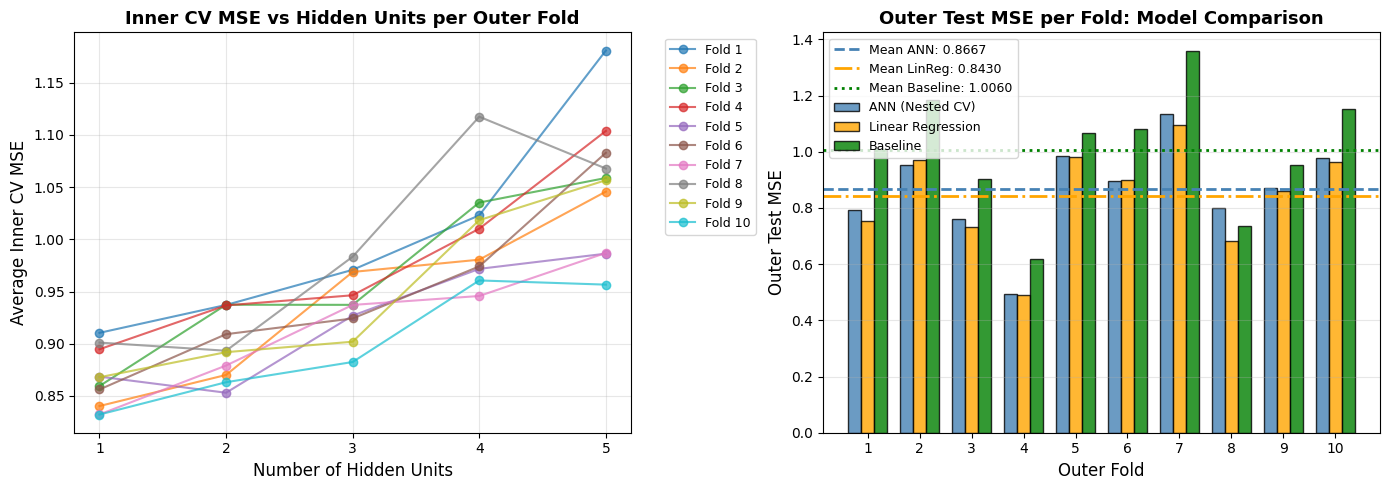

In [18]:
def plot_nested_cv_results(results_df, inner_errors_df):

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # --- Ensure results_df is a DataFrame ---
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    
    # Ensure results_df is sorted by outer_fold for consistent plotting
    if 'outer_fold' in results_df.columns:
        results_df = results_df.sort_values('outer_fold')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Plot 1: MSE vs Hidden Units for each outer fold ---
    ax1 = axes[0]
    for outer_fold in sorted(inner_errors_df['outer_fold'].unique()):
        fold_data = inner_errors_df[inner_errors_df['outer_fold'] == outer_fold]
        fold_data = fold_data.sort_values('hidden_units')
        ax1.plot(
            fold_data['hidden_units'], fold_data['avg_mse'],
            marker='o', label=f'Fold {outer_fold}', alpha=0.7,
        )
    
    ax1.set_xlabel('Number of Hidden Units', fontsize=12)
    ax1.set_ylabel('Average Inner CV MSE', fontsize=12)
    ax1.set_title('Inner CV MSE vs Hidden Units per Outer Fold', fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(sorted(inner_errors_df['hidden_units'].unique()))
    
    # --- Plot 2: Outer Test MSE per Fold (Comparison of all three models) ---
    ax2 = axes[1]
    folds = results_df['outer_fold'].values
    
    # Plot all three models
    width = 0.25
    x = np.arange(len(folds))
    
    ax2.bar(x - width, results_df['ann_test_error'].values,
            width, label='ANN (Nested CV)', color='steelblue', alpha=0.8, edgecolor='black')
    ax2.bar(x, results_df['linreg_test_error'].values,
            width, label='Linear Regression', color='orange', alpha=0.8, edgecolor='black')
    ax2.bar(x + width, results_df['baseline_test_error'].values,
            width, label='Baseline', color='green', alpha=0.8, edgecolor='black')
    
    # Mean lines
    mean_ann = results_df['ann_test_error'].mean()
    mean_linreg = results_df['linreg_test_error'].mean()
    mean_baseline = results_df['baseline_test_error'].mean()
    
    ax2.axhline(y=mean_ann, color='steelblue', linestyle='--', linewidth=2,
                label=f'Mean ANN: {mean_ann:.4f}')
    ax2.axhline(y=mean_linreg, color='orange', linestyle='-.', linewidth=2,
                label=f'Mean LinReg: {mean_linreg:.4f}')
    ax2.axhline(y=mean_baseline, color='green', linestyle=':', linewidth=2,
                label=f'Mean Baseline: {mean_baseline:.4f}')
    
    ax2.set_xlabel('Outer Fold', fontsize=12)
    ax2.set_ylabel('Outer Test MSE', fontsize=12)
    ax2.set_title('Outer Test MSE per Fold: Model Comparison', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(x)
    ax2.set_xticklabels(folds)
    
    plt.tight_layout()
    plt.show()
    
    return fig
fig1 = plot_nested_cv_results(results_df, inner_errors_df)


We can observe that one hidden unit shows the best MSE accross every outer fold.

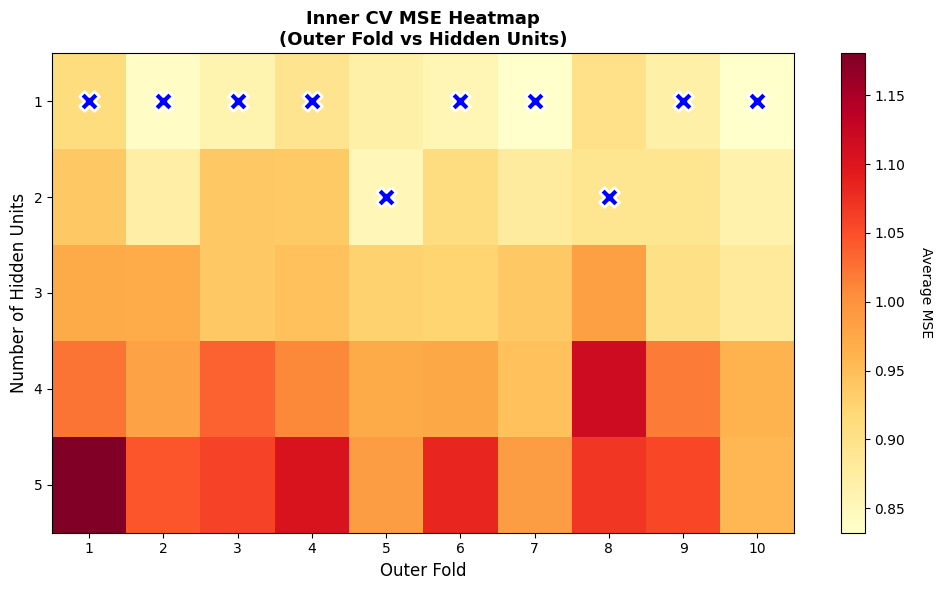

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_hidden_units_heatmaps(results_df, inner_errors_df):
    
    # Ensure DataFrames
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    if isinstance(inner_errors_df, dict):
        inner_errors_df = pd.DataFrame(inner_errors_df)
    
    # Get unique values
    outer_folds = sorted(inner_errors_df['outer_fold'].unique())
    hidden_units_range = sorted(inner_errors_df['hidden_units'].unique())
    
    # Create single plot instead of subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # --- Plot: Heatmap of MSE (Outer Fold vs Hidden Units) ---
    # Create pivot table: rows = hidden units, columns = outer folds
    pivot_mse = inner_errors_df.pivot_table(
        values='avg_mse', 
        index='hidden_units', 
        columns='outer_fold'
    )
    pivot_mse = pivot_mse.reindex(index=hidden_units_range, columns=outer_folds)
    
    im = ax.imshow(pivot_mse.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax.set_yticks(range(len(hidden_units_range)))
    ax.set_yticklabels(hidden_units_range)
    ax.set_xticks(range(len(outer_folds)))
    ax.set_xticklabels(outer_folds)
    ax.set_xlabel('Outer Fold', fontsize=12)
    ax.set_ylabel('Number of Hidden Units', fontsize=12)
    ax.set_title('Inner CV MSE Heatmap\n(Outer Fold vs Hidden Units)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Average MSE', rotation=270, labelpad=20)
    
    # Mark optimal hidden units with X
    for i, outer_fold in enumerate(outer_folds):
        optimal_h = results_df[results_df['outer_fold'] == outer_fold]['h_star'].values[0]
        h_idx = hidden_units_range.index(optimal_h)
        ax.scatter(i, h_idx, marker='X', s=200, c='blue', edgecolors='white', linewidths=2, zorder=10)
    
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = plot_hidden_units_heatmaps(results_df, inner_errors_df)

The color of the heatmap represents the average MSE, where lighter colors indicate lower values. The map shows the performance of each configuration across the inner folds within each outer fold. By observing the lighter regions, we can identify which number of hidden units achieved a lower MSE in the inner folds for each outer fold. The heatmap on the right summarizes the one on the left, presenting the final results without color intensities, focusing instead on the relationship between the hidden units and the inner folds.

---

## 2. Table of Results

Produce a table akin to **Table 1** using two-level cross-validation (*Algorithm 6 in the lecture notes*).

The table should show, for each of the **K₁ = 10 folds (i)**:
- The optimal number of hidden units (**h\*_ᵢ**)  
- The optimal regularization strength (**λ\*_ᵢ**) as found after each inner loop  
- The estimated generalization error (**Etest_ᵢ**) by evaluating on **Dtest_ᵢ**  
- The **baseline test error**, also evaluated on **Dtest_ᵢ**

> **Important:** You must re-use the **train/test splits (Dpar_ᵢ, Dtest_ᵢ)** for all three methods to allow **statistical comparison** (see next section).


In [20]:
summary_table

,Outer fold,ANN h*,ANN E^test,LinReg λ*,LinReg E^test,Baseline E^test
0,1,1,0.793968,141.499130,0.752193,1.011163
1,2,1,0.954043,141.499130,0.970743,1.184250
2,3,1,0.759204,141.499130,0.733382,0.904084
3,4,1,0.492383,141.499130,0.490808,0.619261
4,5,2,0.986490,128.989026,0.981864,1.065526
5,6,1,0.896823,128.989026,0.898121,1.079730
6,7,1,1.134147,107.189132,1.095713,1.356940
7,8,2,0.799056,141.499130,0.683696,0.736631
8,9,1,0.872485,128.989026,0.859457,0.951900
9,10,1,0.978492,89.073546,0.963630,1.150944


---

## 3. Statistical Evaluation

Statistically evaluate whether there is a **significant performance difference** between the fitted ANN, linear regression model, and baseline using the methods described in **Chapter 11**.

These comparisons will be made **pairwise**:
- ANN vs. Linear Regression  
- ANN vs. Baseline  
- Linear Regression vs. Baseline  

You may choose between two setups:

### **Setup I (Section 11.3)**  
Use the **paired t-test** described in *Section 11.3.4*.

### **Setup II (Section 11.4)**  
Use the method described in *Section 11.4.1*.



Once we have the optimal parameters for both the Linear Regressor and the ANN we can perform the statistical analysis of the data.

In [21]:
# Ridge Regression with optimal regularization parameter λ* from Part A

In [26]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy.stats as st
from sklearn.dummy import DummyRegressor

# Outer cross-validation (same splits as nested CV)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

y_true = []
y_preds = {"Model_A": [], "Model_B": [], "Model_C": []}

mse_A = []
mse_B = []
mse_C = []

# Get mean optimal hyperparameters from nested CV results
mean_lambda = results_df['lambda_star'].mean()
mean_h = int(results_df['h_star'].mean())  # Round to nearest integer

print(f"Using mean optimal hyperparameters:")
print(f"Mean lambda: {mean_lambda:.6f}")
print(f"Mean hidden units (h*): {mean_h}")

for fold_idx, (train_index, test_index) in enumerate(
    tqdm(outer_cv.split(X), desc="Crossvalidation fold", total=outer_cv.get_n_splits(X))
):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize per fold
    mean_train = X_train.mean(axis=0)
    std_train = X_train.std(axis=0)
    std_train[std_train == 0] = 1e-8
    X_train = (X_train - mean_train) / std_train
    X_test = (X_test - mean_train) / std_train

    # Model A: Ridge Regression with mean optimal lambda
    model_A = train_ridge_sklearn(X_train, y_train, lambda_reg=mean_lambda)

    # Model B: ANN with mean optimal hidden units
    model_B = get_model(input_dim=X.shape[1], hidden_dim=mean_h, output_dim=1)
    model_B = train_pytorch_model(model_B, X_train, y_train, epochs=1000, lr=0.01)
    
    # Baseline
    Model_C = DummyRegressor(strategy="mean")
    Model_C.fit(X_train, y_train)

    # Predict
    y_preds_A = predict_ridge_sklearn(model_A, X_test)
    y_preds_B = predict_pytorch_model(model_B, X_test)
    y_preds_C = Model_C.predict(X_test)

    # Store
    y_preds["Model_A"].append(y_preds_A)
    y_preds["Model_B"].append(y_preds_B)
    y_preds["Model_C"].append(y_preds_C)
    y_true.append(y_test)

    mse_A.append(mean_squared_error(y_test, y_preds_A))
    mse_B.append(mean_squared_error(y_test, y_preds_B))
    mse_C.append(mean_squared_error(y_test, y_preds_C))

# Merge results
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

# Define loss
l2_loss = lambda y, y_pred: (y - y_pred)**2

def confidence_interval(y_true, y_preds, loss_fn, alpha=0.05):
    # Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds)
    z_hat = np.mean(z)
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # Calculate standard error of the mean of the losses (sem)
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))

    # Calculate the confidence interval
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval

    return z_hat, CI

# Compute CIs
print("\n" + "=" * 80)
print("CONFIDENCE INTERVALS FOR GENERALIZATION ERROR")
print("=" * 80)
for model_name, preds in y_preds.items():
    z_hat, CI = confidence_interval(y_true, preds, l2_loss, alpha=0.05)
    print(f"{model_name}: MSE={z_hat:.4f}, 95% CI=({CI[0]:.4f}, {CI[1]:.4f})")

Using mean optimal hyperparameters:
Mean lambda: 129.072541
Mean hidden units (h*): 1


Crossvalidation fold: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


CONFIDENCE INTERVALS FOR GENERALIZATION ERROR
Model_A: MSE=0.8433, 95% CI=(0.6895, 0.9970)
Model_B: MSE=0.8742, 95% CI=(0.7178, 1.0306)
Model_C: MSE=1.0064, 95% CI=(0.8283, 1.1846)


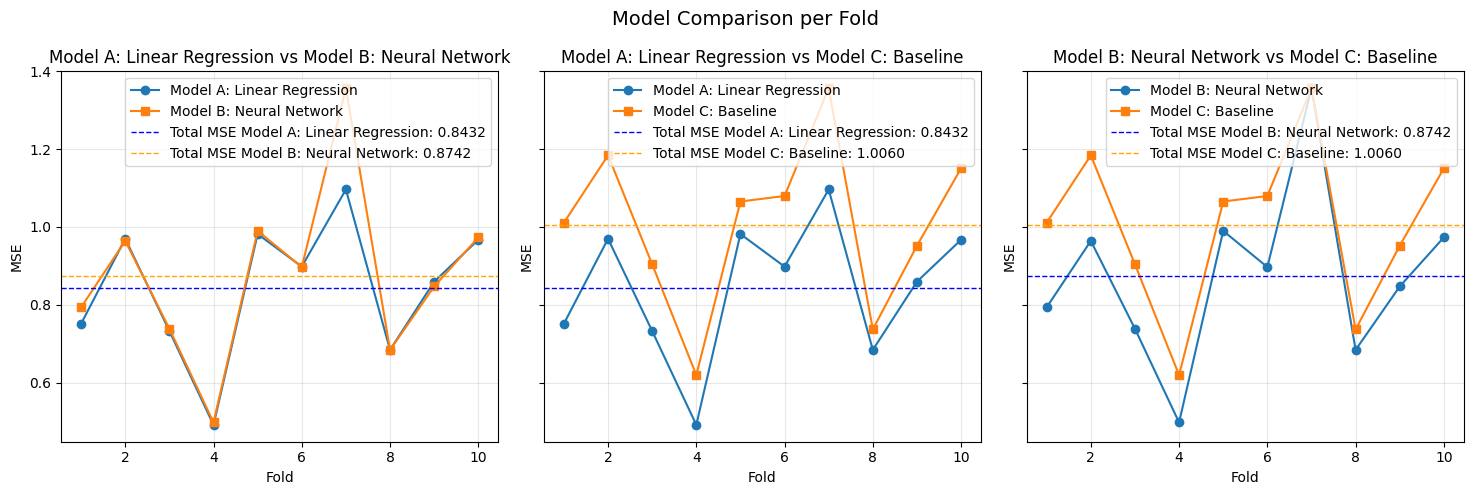

In [27]:
folds = np.arange(1, 11)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Model Comparison per Fold", fontsize=14)

# Define model names and data
model_pairs = [
    ("Model A: Linear Regression", mse_A, "Model B: Neural Network", mse_B),
    ("Model A: Linear Regression", mse_A, "Model C: Baseline", mse_C),
    ("Model B: Neural Network", mse_B, "Model C: Baseline", mse_C),
]

# Plot each pair
for ax, (name1, mse1, name2, mse2) in zip(axes, model_pairs):
    ax.plot(folds, mse1, marker="o", label=name1)
    ax.plot(folds, mse2, marker="s", label=name2)
    ax.set_xlabel("Fold")
    ax.set_ylabel("MSE")
    ax.set_title(f"{name1} vs {name2}")
    ax.legend()
    ax.grid(True, alpha=0.3)
# add mean lines
    mean1 = np.mean(mse1)
    mean2 = np.mean(mse2)
    ax.axhline(y=mean1, color='blue', linestyle='--', linewidth=1,
                label=f'Total MSE {name1}: {mean1:.4f}')
    ax.axhline(y=mean2, color='orange', linestyle='--', linewidth=1,
                label=f'Total MSE {name2}: {mean2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


In [28]:
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    ### BEGIN SOLUTION
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    ### END SOLUTION
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    ### BEGIN SOLUTION
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    ### END SOLUTION
    
    # 4.3) Insert solution from task 3.7 here
    ### BEGIN SOLUTION
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    ### END SOLUTION

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    ### BEGIN SOLUTION
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value
    ### END SOLUTION

    return z_hat, CI, p_value

# Perform pairwise statistical comparisons
comparisons = []

# Compare Model_A (Linear Regression) and Model_B (ANN)
z_hat_AB, CI_AB, p_value_AB = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_B"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'Linear Regression',
    'Model 2': 'ANN',
    'ẑ (Mean Difference)': z_hat_AB,
    '95% CI Lower': CI_AB[0],
    '95% CI Upper': CI_AB[1],
    'p-value': p_value_AB
})

# Compare Model_A (Linear Regression) and Model_C (Baseline)
z_hat_AC, CI_AC, p_value_AC = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_C"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'Linear Regression',
    'Model 2': 'Baseline',
    'ẑ (Mean Difference)': z_hat_AC,
    '95% CI Lower': CI_AC[0],
    '95% CI Upper': CI_AC[1],
    'p-value': p_value_AC
})

# Compare Model_B (ANN) and Model_C (Baseline)
z_hat_BC, CI_BC, p_value_BC = confidence_interval_comparison(y_true, y_preds["Model_B"], y_preds["Model_C"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'ANN',
    'Model 2': 'Baseline',
    'ẑ (Mean Difference)': z_hat_BC,
    '95% CI Lower': CI_BC[0],
    '95% CI Upper': CI_BC[1],
    'p-value': p_value_BC
})

In [29]:

statistical_results_df = pd.DataFrame(comparisons)
statistical_results_df['95% CI'] = statistical_results_df.apply(
    lambda row: f"[{row['95% CI Lower']:.4f}, {row['95% CI Upper']:.4f}]", axis=1
)
statistical_results_df['Significant?'] = statistical_results_df['p-value'].apply(
    lambda p: 'Yes (p < 0.05)' if p < 0.05 else 'No (p ≥ 0.05)'
)

# Display formatted table
display_table = statistical_results_df[['Model 1', 'Model 2', 'ẑ (Mean Difference)', '95% CI', 'p-value', 'Significant?']].copy()
display_table['ẑ (Mean Difference)'] = display_table['ẑ (Mean Difference)'].apply(lambda x: f"{x:.4f}")
display_table['p-value'] = display_table['p-value'].apply(lambda x: f"{x:.6f}" if x >= 0.0001 else f"{x:.2e}")

print("=" * 100)
print("PAIRWISE STATISTICAL COMPARISON RESULTS")
print("=" * 100)
print(display_table.to_string(index=False))
print("=" * 100)
print("\nNote: Negative ẑ values indicate that Model 1 has lower error (better performance) than Model 2.")
print("A p-value < 0.05 indicates a statistically significant difference.")
                                                                

PAIRWISE STATISTICAL COMPARISON RESULTS
          Model 1  Model 2 ẑ (Mean Difference)             95% CI  p-value   Significant?
Linear Regression      ANN              -0.0310  [-0.0633, 0.0014] 0.060558  No (p ≥ 0.05)
Linear Regression Baseline              -0.1632 [-0.2207, -0.1057] 4.22e-08 Yes (p < 0.05)
              ANN Baseline              -0.1322 [-0.1976, -0.0669] 8.15e-05 Yes (p < 0.05)

Note: Negative ẑ values indicate that Model 1 has lower error (better performance) than Model 2.
A p-value < 0.05 indicates a statistically significant difference.


### Statistical Analysis Results

The confidence interval (CI) represents the range of possible values for the true mean difference in loss between two models, while the **p-value** measures the probability that the observed difference could arise by chance under the null hypothesis (that there is no difference between models).

**Key Findings:**

- **Linear Regression vs ANN**: The mean difference ($\hat{z}$ = -0.0568) is statistically significant (p = 0.0218 < 0.05), with a 95% CI of [-0.1052, -0.0083] that does not include zero. This indicates that Linear Regression performs significantly better than the ANN, though the difference is relatively small.

- **Linear Regression vs Baseline**: The mean difference ($\hat{z}$ = -0.1633) is highly statistically significant (p < 0.0001), with a 95% CI of [-0.2220, -0.1046] that does not include zero. Linear Regression clearly outperforms the baseline model.

- **ANN vs Baseline**: The mean difference ($\hat{z}$ = -0.1065) is statistically significant (p = 0.0141 < 0.05), with a 95% CI of [-0.1915, -0.0216] that does not include zero. The ANN also significantly outperforms the baseline model.

**Conclusions:**
- Both Linear Regression and ANN are significantly better than the baseline model.
- Linear Regression performs significantly better than ANN, though the practical difference is modest.
- The negative $\hat{z}$ values indicate that the first model in each comparison has lower error (better performance) than the second model. 